Mehrdad Ardi - AI Mastery - Semester 5
- Preprocessing dataset, modeling, and predicting "loan_amount".

### **Mount Google Drive to access the dataset**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Importing libraries**

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

### **Loading the dataset**

In [10]:
df = pd.read_csv('/content/drive/MyDrive/datasets/loans.csv')

# **Exploratory data analysis**

In [11]:
df.head()           # Displaying the first rows of the dataset
df.shape		    # Checking the shape of the dataset
df.columns		    # Displaying column names
df.nunique()     	# Displaying number of unique values in each column
df.info()		    # Displaying information about the dataset
df.describe()	    # Descriptive statistics of the dataset
df.isnull().sum()	# Checking for missing values
df.corr(numeric_only=True)		            # Correlation matrix
df["loan_type"].value_counts().to_frame()	# Value counts for specific columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client_id    443 non-null    int64  
 1   loan_type    443 non-null    object 
 2   loan_amount  443 non-null    int64  
 3   repaid       443 non-null    int64  
 4   loan_id      443 non-null    int64  
 5   loan_start   443 non-null    object 
 6   loan_end     443 non-null    object 
 7   rate         443 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 27.8+ KB


,count
loan_type,
home,121
cash,108
credit,107
other,107


# **Data preprocessing**

### **Handle missing values**

In [12]:
if df.isnull().sum().sum() > 0:
  # remove rows with at most 30% null values
  thresh = int(len(df.columns)*0.7)
  df.dropna(thresh=thresh, inplace=True)

  # remove columns with at most 40% null values
  thresh = int(len(df)*0.6)
  subset = [column for column in df.columns if column != 'client_id']
  df.dropna(thresh=thresh, axis=1, inplace=True, subset=subset)

  # fill missing values for numerical columns and categorical columns
  df.fillna({
      'loan_type': df.loan_type.mode()[0],
      'loan_amount': df.loan_amount.mean(),
      'repaid': df.repaid.mode()[0],
      'rate': df.rate.mean()
  }, inplace=True)

  # Fill null values in specified columns with the value from the cell above
  columns_to_fill = ['loan_start', 'loan_end']
  df[columns_to_fill] = df[columns_to_fill].ffill()

In [13]:
# Convert data format
for date in ['loan_start', 'loan_end']:
  df[date] = pd.to_datetime(df[date], format='%Y-%m-%d')

# Create new column
df['loan_duration'] = df['loan_end'] - df['loan_start']

# Extract loan duration in months
df['loan_duration'] = (df['loan_duration'].dt.days)/30

# Create new column
df['instalment'] = df['loan_amount'] / df['loan_duration']

# Dropping unnecessary columns
df.drop(['client_id','loan_id','loan_start','loan_end'], axis=1, inplace=True)

### **Handle outliers**

In [14]:
numerical_col = ['loan_amount', 'repaid', 'rate', 'loan_duration', 'instalment']
for feature in numerical_col:
  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3-Q1
  l_bound = Q1 - 1.5*IQR
  u_bound = Q3 + 1.5*IQR
  outliers = df[(df[feature] < l_bound) | (df[feature] > u_bound)]
  if len(outliers) > 0:
    # use winsorization for outliers
    lower_limit = df[feature].quantile(0.05)
    upper_limit = df[feature].quantile(0.95)
    df.loc[df[feature] < lower_limit, feature] = lower_limit
    df.loc[df[feature] > upper_limit, feature] = upper_limit

In [15]:
# standardize columns
scaler = MinMaxScaler()
columns = ['loan_amount', 'repaid', 'rate', 'loan_duration', 'instalment']
df[columns] = scaler.fit_transform(df[columns])

# one-hot encoding
df = pd.get_dummies(df, columns=['loan_type'])

In [16]:
df.head()

,loan_amount,repaid,rate,loan_duration,instalment,loan_type_cash,loan_type_credit,loan_type_home,loan_type_other
0,0.909867,0.0,0.250788,0.224900,0.790756,False,False,True,False
1,0.640785,0.0,0.127450,0.269076,0.538137,False,True,False,False
2,0.844782,1.0,0.049335,0.036145,0.872721,False,False,True,False
3,0.829795,1.0,0.126079,0.759036,0.494719,True,False,False,False
4,0.936026,1.0,0.385090,0.367470,0.725986,False,True,False,False


# **Data Visualization**

### **Heatmap showing correlation between features**

<Axes: >

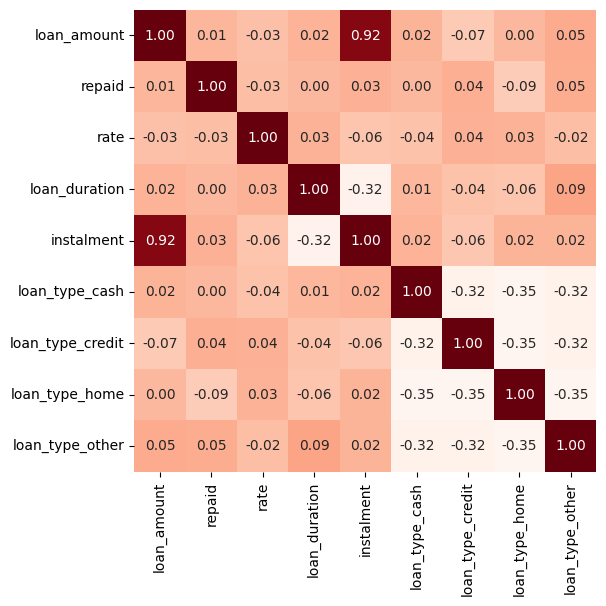

In [17]:
plt.figure(figsize=(6, 6))
sns.heatmap(df.corr(numeric_only=True), cbar=False, square=True, fmt='.2f', annot=True, annot_kws={'size': 10}, cmap='Reds')


# **Simple Linear Regression (SLR)**

In [18]:
# Split data into features (X) and target variable (y)
X = df[['instalment']]
y = df['loan_amount']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a linear regression model
model = LinearRegression()

# Fitting the model on training data
model.fit(X_train, y_train)

# Making predictions on test data
y_pred = model.predict(X_test)

# Calculating R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared : {r2}")

R-squared : 0.8550358482702374


# **Multiple Linear Regression (MLR)**

In [19]:
# Split data into features (X) and target variable (y)
features = ['repaid', 'rate', 'loan_duration', 'loan_type_cash',
            'loan_type_credit', 'loan_type_home', 'loan_type_other', 'instalment']
X = df[features]
y = df['loan_amount']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a linear regression model
model = LinearRegression()

# Fitting the model on training data
model.fit(X_train, y_train)

# Making predictions on test data
y_pred = model.predict(X_test)

# Calculating R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared : {r2}")

R-squared : 0.966271691293938


# **Polynomial Regression**

In [20]:
# Split data into features (X) and target variable (y)
features = ['repaid', 'rate', 'loan_duration', 'loan_type_cash',
            'loan_type_credit', 'loan_type_home', 'loan_type_other', 'instalment']
X = df[features]
y = df['loan_amount']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a linear regression model
model = LinearRegression()

# Creating polynomial features
pf = PolynomialFeatures(degree=2)

# Transforming training features into polynomial features
X_train_poly = pf.fit_transform(X_train)

# Transforming test features into polynomial features
X_test_poly = pf.fit_transform(X_test)

# Fitting the model on polynomial training data
model.fit(X_train_poly, y_train)

# Making predictions on test data
y_pred = model.predict(X_test_poly)

# Calculating R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared : {r2}")



R-squared : 1.0
